In [1]:
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

%matplotlib inline

In [2]:
df = pd.read_excel('database/Processos_autuados_de_2006_a_2018.xlsx')

# Dado Original

In [3]:
df.shape

(167547, 7)

In [4]:
df.head()

,NPU/ EXPEDIENTE,NPU/ EXPEDIENTE.1,NPU/ EXPEDIENTE.2,NPU/ EXPEDIENTE.3,NPU/ EXPEDIENTE.4,NPU/ EXPEDIENTE.5,NPU/ EXPEDIENTE.6
0,0000001-05.2016.8.17.0380,1002-32.2017.8.17.1110,0000001-95.2017.8.17.1050,0000001-44.2016.8.17.0270,0000001-44.2016.8.17.0270,0000441-53.2017.8.17.0610,0000001-05.2016.8.17.0380
1,0000001-10.2016.8.17.1510,0000001-08.2009.8.17.1590,0000014-08.2011.8.17.1470,0000004-30.2018.8.17.1110,0000004-30.2018.8.17.1110,2018.0581.001689,0000001-08.2009.8.17.1590
2,0000001-11.2018.8.17.0420,0000001-09.2018.8.17.1520,0000023-02.2018.8.17.0410,0000008-52.2018.8.17.0630,0000008-52.2018.8.17.0630,2018.0581.005356,0000001-09.2018.8.17.1520
3,0000001-12.2018.8.17.0840,0000001-11.2018.8.17.0420,0000028-24.2018.8.17.0410,0000008-71.2016.8.17.1390,0000008-71.2016.8.17.1390,2018.0581.006859,0000001-10.2016.8.17.1510
4,0000001-13.2017.8.17.0560,0000001-12.2017.8.17.0140,0000029-09.2018.8.17.0410,0000010-86.2018.8.17.0350,0000010-86.2018.8.17.0350,2018.0581.007302,0000001-11.2018.8.17.0420


## Agrupar os dados

In [5]:
new_df = pd.concat([df['NPU/ EXPEDIENTE'], df['NPU/ EXPEDIENTE.1'], df['NPU/ EXPEDIENTE.2'], df['NPU/ EXPEDIENTE.3'],
                    df['NPU/ EXPEDIENTE.4'], df['NPU/ EXPEDIENTE.5'], df['NPU/ EXPEDIENTE.6']
                   ],
                   ignore_index=True)

In [6]:
new_df.tail()

1172824    9900020-72.2014.8.17.0420
1172825    9900021-53.2012.8.17.1220
1172826    9900021-91.2013.8.17.0420
1172827    9900081-15.2012.8.17.0480
1172828    9900098-51.2012.8.17.0480
dtype: object

Quantidade de campos que estão nulos:

In [7]:
new_df.isna().sum(), new_df.shape[0]

(837690, 1172829)

In [8]:
new_df = new_df.dropna()

In [9]:
new_df.shape[0]

335139

Remove numeros duplicados:

In [10]:
new_df = new_df.drop_duplicates()

Nova quantidade de amostras:

In [11]:
new_df.shape[0]

143933

## Dividir dados por tipo de número

In [12]:
def parse_npu(numero):
    numero = u''.join(re.findall(r'\d+', numero))
    numero = numero.zfill(20)
    return {
        'sequencial': numero[0:7],
        'digito': numero[7:9],
        'ano': numero[9:13],
        'justica': numero[13:14],
        'tribunal': numero[14:16],
        'origem': numero[16:20]
    }

def get_ano(numero):
    campos = parse_npu(numero)
    return int(campos['ano'])

def is_recife(numero):
    campos = parse_npu(numero)
    if campos['origem'] == '0001':
        return True
    return False

def is_npu(numero):
    if len(numero) == 16:
        return False
    campos = parse_npu(numero)
    return (campos['sequencial'] != '0000000'
            and 1900 <= int(campos['ano']) <= date.today().year
            and campos['justica'] != '0')

def is_execucao(numero):
    if len(numero) == 16:
        return True
    return False

### NPU e EXECUCAO

In [13]:
df_npu = new_df[new_df.apply(is_npu)]
df_execucao = new_df[new_df.apply(is_execucao)]

In [14]:
df_npu.shape, df_execucao.shape

((142951,), (982,))

### RECIFE

In [15]:
df_recife = df_npu[df_npu.apply(is_recife)]

In [16]:
df_recife.shape

(27774,)

#### ANOS

In [17]:
anos = np.array(df_recife.apply(get_ano))
npus = np.array(df_recife)

In [18]:
df_npu_recife = pd.DataFrame({'npu': npus, 'ano': anos})

In [19]:
df_npu_recife['ano'].value_counts()

2015    3590
2013    3416
2014    3244
2018    2887
2012    2616
2010    2477
2016    2460
2011    2315
2017    2314
2009    1716
2008     490
2007     221
2006      26
2005       1
2004       1
Name: ano, dtype: int64

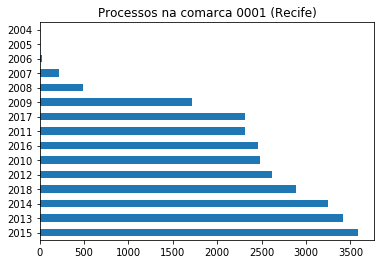

In [20]:
fig = plt.figure()
title = 'Processos na comarca 0001 (Recife)'
df_npu_recife['ano'].value_counts().plot.barh(title=title)
fig.savefig('figures/{}'.format(title), dpi=100, bbox_inches='tight')

## Gerando CSV

In [21]:
df_recife.to_csv('database/npus_recife.csv', index = None, header=False)